In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "/disk_c/han/data/celeba_org/"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

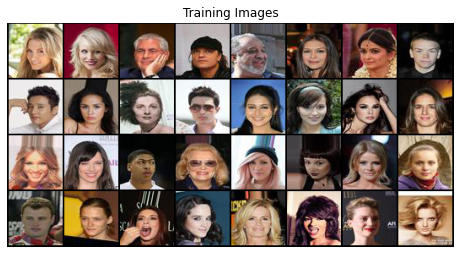

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [20]:
# Autoencoder Code
'''Sub class the nn module'''
class AE(nn.Module):
    def __init__(self, ngpu):
        super(AE, self).__init__() #not a python thing
        self.ngpu = ngpu
        
        self.encoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            Flatten()
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( ndf*8*4*4, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        enc = self.encoder(input)
        enc = enc.unsqueeze(-1).unsqueeze(-1)
        return self.decoder(enc)

# Create the generator
netAE = AE(ngpu).to(device) # adding it to the device

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netAE = nn.DataParallel(netAE, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netAE.apply(weights_init)

# Print the model
print(netAE)

AE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8192, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

In [21]:
criterion = nn.MSELoss()

# Setup Adam optimizers for both G and D
optimizerAE = optim.Adam(netAE.parameters(), lr=lr, betas=(beta1, 0.999))

In [22]:
# Training Loop

# Lists to keep track of progress
AE_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update AE network
        ###########################
        ## Train with all-real batch
        netAE.zero_grad() 
        
        img = data[0].to(device) 
        
        output = netAE(img) 
        errAE = criterion(output, img)  
        errAE.backward()
        optimizerAE.step()
        
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errAE.item()))
            
        iters += 1

Starting Training Loop...
[0/5][0/313]	Loss_D: 0.4094
[0/5][50/313]	Loss_D: 0.0930
[0/5][100/313]	Loss_D: 0.0709
[0/5][150/313]	Loss_D: 0.0620
[0/5][200/313]	Loss_D: 0.0446
[0/5][250/313]	Loss_D: 0.0461
[0/5][300/313]	Loss_D: 0.0466
[1/5][0/313]	Loss_D: 0.0522
[1/5][50/313]	Loss_D: 0.0425
[1/5][100/313]	Loss_D: 0.0436
[1/5][150/313]	Loss_D: 0.0373
[1/5][200/313]	Loss_D: 0.0383
[1/5][250/313]	Loss_D: 0.0376
[1/5][300/313]	Loss_D: 0.0327
[2/5][0/313]	Loss_D: 0.0344
[2/5][50/313]	Loss_D: 0.0316
[2/5][100/313]	Loss_D: 0.0330
[2/5][150/313]	Loss_D: 0.0336
[2/5][200/313]	Loss_D: 0.0318
[2/5][250/313]	Loss_D: 0.0298
[2/5][300/313]	Loss_D: 0.0323
[3/5][0/313]	Loss_D: 0.0328
[3/5][50/313]	Loss_D: 0.0311
[3/5][100/313]	Loss_D: 0.0312
[3/5][150/313]	Loss_D: 0.0281
[3/5][200/313]	Loss_D: 0.0255
[3/5][250/313]	Loss_D: 0.0265
[3/5][300/313]	Loss_D: 0.0323
[4/5][0/313]	Loss_D: 0.0282
[4/5][50/313]	Loss_D: 0.0322
[4/5][100/313]	Loss_D: 0.0266
[4/5][150/313]	Loss_D: 0.0307
[4/5][200/313]	Loss_D: 0.0264

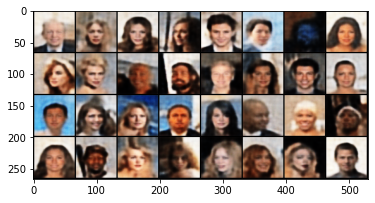

In [23]:
with torch.no_grad():
    for data in dataloader:
        img = data[0].to(device)
        grid = netAE(img).detach().cpu()
        plt.imshow(np.transpose(vutils.make_grid(grid, padding=2, normalize=True).cpu(),(1,2,0)))
        break

In [33]:
# Generator Code
'''Sub class the nn module'''
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__() #not a python thing
        self.ngpu = ngpu
        self.encoder = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            Flatten()
        )
        
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( ndf*8*4*4, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        enc = self.encoder(input)
        enc = enc.unsqueeze(-1).unsqueeze(-1)
        return self.decoder(enc)

# Create the generator
netG = Generator(ngpu).to(device) # adding it to the device

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8192, 512, kernel_size=(4, 4), stride=(1, 1), bias=Fals

In [34]:

    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(2*nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            Flatten(),
            nn.Linear(ndf*8*4*4,1),
#             nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image, label):
        input = torch.cat((image,label),1)
        return self.main(input)

# Create the Discriminator
netD = Discriminator(ngpu).to(device) #addting it to the device

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Flatten()
    (12): Linear(in_features=8192, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [35]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size*2, nz, 1, 1, device=device) #adding it to the device

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [38]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad() #zero out the gradient buffer. I don't think I know what this is exactly
        # Format batch
        real_cpu = data[0].to(device) #not sure why this is called real_cpu since the device is set to GPU
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device) #why not use the batch_size param here.
        
        with torch.no_grad():
            class_ = netAE(real_cpu).detach()
        
        
        # Forward pass real batch through D
        output = netD(real_cpu,class_).view(-1) #not sure what this view thing is doing
        # Calculate loss on all-real batch
        errD_real = criterion(output, label) #criterion can be any function 
        # Calculate gradients for D in backward pass
        errD_real.backward() #calc the error
        D_x = output.mean().item() #no idea what this is, but probably just the logits. Why get the mean or item?

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(real_cpu)
        label.fill_(fake_label) #why not just repeat the label creation ?
        # Classify all fake batch with D
        output = netD(fake.detach(),class_).view(-1) #why detach? ah I think it is because the params save the gradients
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step() #but how did the optimizer get the error? do the params save their own gradients in pytorch?

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake,real_cpu).view(-1) #that is why here we do not detach
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(real_cpu).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/5][0/313]	Loss_D: 1.5225	Loss_G: 2.0551	D(x): 0.6604	D(G(z)): 0.6451 / 0.1661
[0/5][50/313]	Loss_D: 0.1451	Loss_G: 3.2575	D(x): 0.8971	D(G(z)): 0.0297 / 0.0505
[0/5][100/313]	Loss_D: 0.6234	Loss_G: 3.5925	D(x): 0.8692	D(G(z)): 0.3500 / 0.0366
[0/5][150/313]	Loss_D: 0.0657	Loss_G: 4.1962	D(x): 0.9834	D(G(z)): 0.0467 / 0.0207
[0/5][200/313]	Loss_D: 0.0120	Loss_G: 3.8312	D(x): 0.9986	D(G(z)): 0.0105 / 0.0289
[0/5][250/313]	Loss_D: 0.0139	Loss_G: 3.9418	D(x): 0.9954	D(G(z)): 0.0092 / 0.0285
[0/5][300/313]	Loss_D: 0.1221	Loss_G: 4.6792	D(x): 0.9754	D(G(z)): 0.0874 / 0.0150
[1/5][0/313]	Loss_D: 0.2665	Loss_G: 4.4048	D(x): 0.9948	D(G(z)): 0.2003 / 0.0174
[1/5][50/313]	Loss_D: 0.0226	Loss_G: 4.6848	D(x): 0.9969	D(G(z)): 0.0191 / 0.0161
[1/5][100/313]	Loss_D: 0.2688	Loss_G: 3.4605	D(x): 0.9334	D(G(z)): 0.1740 / 0.0377
[1/5][150/313]	Loss_D: 0.0218	Loss_G: 3.8400	D(x): 0.9908	D(G(z)): 0.0122 / 0.0315
[1/5][200/313]	Loss_D: 0.0041	Loss_G: 6.3222	D(x): 0.9986	D(G(z)): 

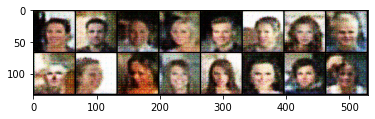

In [41]:
with torch.no_grad():
    fake = img_list[-1]
    plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu(),(1,2,0)))